In [18]:
import numpy as np
import librosa
import glob
import pickle
from tqdm import tqdm

from MusicVectorizer import MusicVectorizer

SAMPLE_RATE = 16000

In [19]:
data_folders = ["90s_hiphop", "90s_rock", "2010s_pop", "classical", "country"]

In [20]:
# load trajectories
trajectories = dict()
for folder in data_folders:
    trajectories[folder] = np.load(f"data/{folder}_trajectories.npy", allow_pickle=True).item()

In [21]:
lengths = list()
for folder in data_folders:
    for file in trajectories[folder]:
        lengths.append(trajectories[folder][file].shape[0])

In [22]:
# total number of features that we have:
N = np.sum(lengths)
N

19218

In [23]:
X = np.zeros((N, 13, 768))
y = np.zeros(N)

i = 0
for idx, genre in enumerate(data_folders):
    for file in trajectories[genre]:
        X[i:i+trajectories[genre][file].shape[0], :, :] = trajectories[genre][file]
        y[i:i+trajectories[genre][file].shape[0]] = idx
        i += trajectories[genre][file].shape[0]

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', categories='auto')
y = enc.fit_transform(y.reshape(-1, 1)).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [26]:
# Crazy Torch Model
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      # First fully connected layer
      self.fc1 = nn.Linear(13 * 768, 768)
      
      # Get outputs
      self.fc2 = nn.Linear(768,5)
      
    def forward(self, x):
      outputs = F.relu(self.fc1(x))
      outputs = F.sigmoid(self.fc2(outputs))
      return outputs

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = Net().to(device)
print(model, device)

Net(
  (fc1): Linear(in_features=9984, out_features=768, bias=True)
  (fc2): Linear(in_features=768, out_features=5, bias=True)
) cuda


In [28]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [29]:
# GET DATA HERE
X_train, X_test = torch.Tensor(X_train).flatten(start_dim=1).to(device) ,torch.Tensor(X_test).flatten(start_dim=1).to(device)
y_train, y_test = torch.Tensor(y_train).to(device) ,torch.Tensor(y_test).to(device)

In [63]:
from torchmetrics.functional import accuracy as torch_acc

epochs = 50000

losses_train = []
losses_test = []
accuracies_test = []
accuracies_train = []
iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1

    if iter%1000==0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = torch.zeros_like(outputs_test)
            predicted_test.scatter_(1, torch.argmax(outputs_test, 1).unsqueeze(1), 1)
            accuracy_test = torch_acc(predicted_test, y_test, task='multiclass', num_classes=5).cpu()

            losses_test.append(loss_test.item())
            accuracies_test.append(accuracy_test)
            
            # Calculating the loss and accuracy for the train dataset
            predicted_train = torch.zeros_like(outputs)
            predicted_train.scatter_(1, torch.argmax(outputs, 1).unsqueeze(1), 1)
            accuracy_train = torch_acc(predicted_train, y_train, task='multiclass', num_classes=5).cpu()

            losses_train.append(loss.item())
            accuracies_train.append(accuracy_train)

            iterations.append(iter)

            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy_train}\n")

            if iter % 10000 == 0:
                torch.save(model.state_dict(), f"models/model_{iter}.pt")

Training Epochs:   0%|          | 0/10 [00:00<?, ?it/s]/home/shrey/.local/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Training Epochs:  20%|██        | 2/10 [00:00<00:00,  8.24it/s]

Iteration: 1. 
Test - Loss: 0.6131106019020081. Accuracy: 0.7567117810249329
Train -  Loss: 0.6161271929740906. Accuracy: 0.7577468156814575

Iteration: 2. 
Test - Loss: 0.6100286841392517. Accuracy: 0.7593132257461548
Train -  Loss: 0.6129999756813049. Accuracy: 0.7597241997718811



Training Epochs:  40%|████      | 4/10 [00:00<00:00,  8.72it/s]

Iteration: 3. 
Test - Loss: 0.6069898009300232. Accuracy: 0.7604578733444214
Train -  Loss: 0.6099167466163635. Accuracy: 0.7613633275032043

Iteration: 4. 
Test - Loss: 0.6039935946464539. Accuracy: 0.761706531047821
Train -  Loss: 0.6068766713142395. Accuracy: 0.7624040842056274



Training Epochs:  60%|██████    | 6/10 [00:00<00:00,  8.91it/s]

Iteration: 5. 
Test - Loss: 0.6010398864746094. Accuracy: 0.7627471089363098
Train -  Loss: 0.6038796305656433. Accuracy: 0.7635488510131836

Iteration: 6. 
Test - Loss: 0.5981285572052002. Accuracy: 0.7630593180656433
Train -  Loss: 0.6009253859519958. Accuracy: 0.7641212344169617



Training Epochs:  80%|████████  | 8/10 [00:00<00:00,  9.10it/s]

Iteration: 7. 
Test - Loss: 0.5952602624893188. Accuracy: 0.7630593180656433
Train -  Loss: 0.5980136394500732. Accuracy: 0.7645115256309509

Iteration: 8. 
Test - Loss: 0.5924343466758728. Accuracy: 0.7624349594116211
Train -  Loss: 0.5951445698738098. Accuracy: 0.7646415829658508



Training Epochs: 100%|██████████| 10/10 [00:01<00:00,  8.81it/s]

Iteration: 9. 
Test - Loss: 0.5896510481834412. Accuracy: 0.7622268199920654
Train -  Loss: 0.5923179388046265. Accuracy: 0.7647976875305176

Iteration: 10. 
Test - Loss: 0.5869109034538269. Accuracy: 0.7620187401771545
Train -  Loss: 0.5895339250564575. Accuracy: 0.7647716999053955



In [62]:
import matplotlib.pyplot as plt

/home/shrey/.local/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(1.5105)

29032

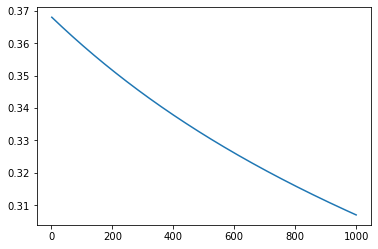

In [73]:
import matplotlib.pyplot as plt 
plt.plot(Iterations, losses, label="Train")

In [58]:
losses

[]